# Seq2Seq (Encoder-Decoder) Model
this model is the basic encoder decoder model without attention mechanism.

In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [2]:
vocab_size = 256  # ascii size
x_ = list(map(ord, "hello"))  # convert to list of ascii codes
y_ = list(map(ord, "hola"))   # convert to list of ascii codes
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
x = Variable(th.LongTensor(x_))
y = Variable(th.LongTensor(y_))

In [4]:
print(x)

Variable containing:
 104
 101
 108
 108
 111
[torch.LongTensor of size 5]



In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.LSTM(hidden_size, hidden_size)
        self.decoder = nn.LSTM(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # Encoder inputs and states
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding = [seq_len, batch_size, embedding_size]
        
        # Encoder
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # Decoder inputs and states
        decoder_state = encoder_state
        decoder_input = Variable(th.LongTensor([[0]]))
        
        # Decoder
        outputs = []
        for i in range(targets.size()[0]): 
            decoder_input = self.embedding(decoder_input)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            
            # Project to the vocabulary size
            projection = self.project(decoder_output.view(1, -1))  # batch x vocab_size
            
            # Make prediction
            prediction = F.softmax(projection)  # batch x vocab_size
            outputs.append(prediction)
            
            # update decoder input
            _, top_i = prediction.data.topk(1)  # 1 x 1
            decoder_input = Variable(top_i)

        outputs = th.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return (
            Variable(weight.new(self.n_layers, batch_size, self.hidden_size).zero_()),
            Variable(weight.new(self.n_layers, batch_size, self.hidden_size).zero_())
        )

In [6]:
seq2seq = Seq2Seq(vocab_size, 16)
print(seq2seq)
pred = seq2seq(x, y)
print(pred)

Seq2Seq (
  (embedding): Embedding(256, 16)
  (encoder): LSTM(16, 16)
  (decoder): LSTM(16, 16)
  (project): Linear (16 -> 256)
)
Variable containing:
1.00000e-03 *
 3.4673  3.1261  4.1585  ...   4.6288  3.6917  3.8299
 3.4849  2.7723  4.2419  ...   4.2775  4.1550  3.9051
 3.7341  3.1222  4.4263  ...   3.9580  4.7413  4.1943
 3.5559  3.1149  4.1837  ...   3.7882  4.2197  3.5986
[torch.FloatTensor of size 4x256]



In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(seq2seq.parameters(), lr=1e-3)

In [8]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data[0]
    log.append(loss_val)
    if i % 100 == 0:
        print("%d loss: %s" % (i, loss_val))
        _, top1 = prediction.data.topk(1, 1)
        for c in top1.squeeze().numpy().tolist():
            print(chr(c), end=" ")
        print()

0 loss: 5.545517921447754
E Q + ô 
100 loss: 5.405981063842773
h h h h 
200 loss: 5.047115802764893
h o a a 
300 loss: 4.872081279754639
h o a a 
400 loss: 4.728263854980469
h o l a 
500 loss: 4.6287384033203125
h o l a 
600 loss: 4.592064380645752
h o l a 
700 loss: 4.576397895812988
h o l a 
800 loss: 4.5692291259765625
h o l a 
900 loss: 4.564873695373535
h o l a 


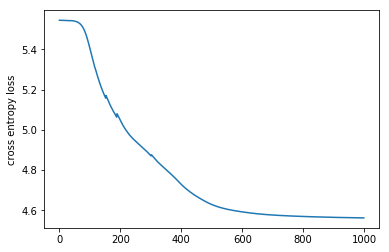

In [10]:
import matplotlib.pyplot as plt
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()